In [363]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, HMC, NUTS, mcmc_kernel

from pyro.optim import Adam
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [364]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

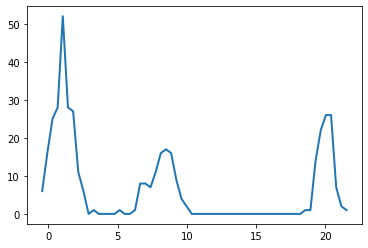

In [365]:
data = torch.cat((Normal(20, .5).sample([100]),
                  Normal(8, 1.).sample([100]),
                  Normal(1.5, .5).sample([100]),
                  Normal(0.5, .5).sample([100])))

hist, bin_edges = np.histogram(data, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, lw=2)


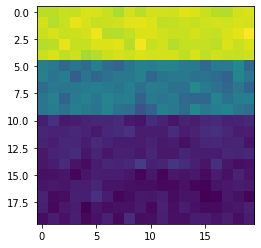

In [366]:
import random
plt.imshow(np.reshape(data, (20,20)))


In [430]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", Normal(0., 5.))
    
    with pyro.plate("sigma_plate", T):
        sigma = pyro.sample("sigma", Uniform(0,1))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) 
        pyro.sample("obs", Normal(mu[z], sigma[z]), obs=data)

    return beta,mu,z

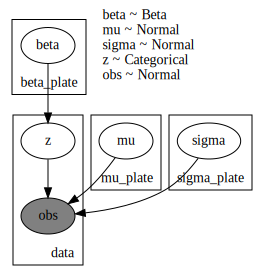

In [405]:
T = 6
N = 400
alpha = 0.05
pyro.render_model(model, model_args=(data,), render_distributions=True)

In [432]:
data = torch.reshape(torch.tensor(data), (-1,))

pyro.clear_param_store()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=500, num_chains=1)
mcmc.run(data=data)
mcmc.summary()

Sample: 100%|██████████| 1000/1000 [10:34,  1.58it/s, step size=9.22e-02, acc. prob=0.726]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.22      0.06      0.24      0.13      0.30     11.92      1.01
   beta[1]      0.33      0.29      0.47      0.00      0.66      4.17      1.25
   beta[2]      0.42      0.25      0.45      0.01      0.70      4.81      1.25
   beta[3]      0.99      0.03      1.00      0.96      1.00     66.76      1.00
   beta[4]      0.91      0.18      1.00      0.68      1.00    379.65      1.00
     mu[0]      8.26      0.25      8.21      7.94      8.68     15.56      1.05
     mu[1]     -1.47      3.54      0.96     -7.42      1.27      4.49      1.31
     mu[2]      3.06      3.85      1.13      0.94      8.86      9.07      1.00
     mu[3]     20.02      0.06     20.02     19.93     20.11    188.42      1.02
     mu[4]      0.14      4.78      0.28     -9.05      7.24    375.66      1.00
     mu[5]      0.24      4.89      0.45     -7.75      8.35    334.64      1.00
  sigma[0]      0.84      0

In [433]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)

beta = mcmc_samples['beta'][0]
mu = mcmc_samples['mu'][0]
sigma = mcmc_samples['sigma'][0]

torch.Size([1, 500, 6])


<AxesSubplot:ylabel='Density'>

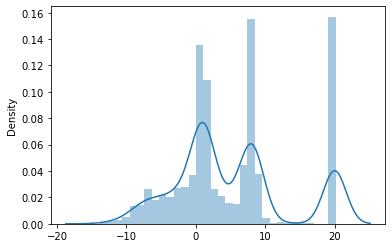

In [434]:
import seaborn as sns

print(mcmc_samples['mu'].shape)
sns.distplot(mcmc_samples["mu"])

In [435]:
# d =  torch.tensor(data, dtype=torch.float)
# samples = mcmc.get_samples()

# for k, v in samples.items():
#     print(f"{k}: {tuple(v.shape)}")

# predictive = Predictive(model, samples)(d)

In [ ]:
print(beta[0])
print(mix_weights(beta[0]))
Categorical(mix_weights(beta[0])).sample([1])

In [436]:
def predict(i,beta,mu):

    z = pyro.sample("z", Categorical(mix_weights(beta)))#torch.ones(T)*1/T)) 
    pyro.sample("obs", Normal(mu[z], sigma[z]), obs=i)
    
    return z

In [438]:
x =[]
clusts = []
for i in data:
    for b, m in zip(beta,mu):
        x.append(predict(i,b,m))
    clusts.append(torch.mode(torch.tensor(x)).values)

print(len(clusts))
    

400


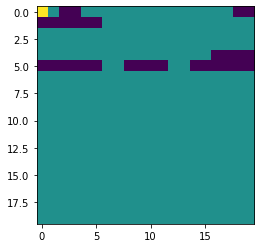

In [439]:
plt.imshow(np.reshape(clusts, (20,20)))
